In [14]:
import joblib
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

## Evaluación de Escenarios

Una vez entrenados y optimizados los modelos, se generaron los pronósticos para Facturación y Saldo considerando los escenarios definidos (Base, Pesimista y Alterno).  
El proceso de evaluación incluyó:

1. **Preparación de los datos futuros:**  
   - Las proyecciones macroeconómicas se organizaron por escenario y se integraron con los datos históricos.
   - Se utilizaron los valores de cierre a diciembre de 2024 como punto inicial para transformar las predicciones porcentuales en valores absolutos.

2. **Generación de predicciones:**  
   - Para cada escenario se generaron pronósticos con los tres modelos (Ridge, SARIMAX y Prophet) y se calculó un modelo combinado (ensemble) como promedio de estos.
   - Las predicciones fueron obtenidas tanto en cambios porcentuales como en valores absolutos acumulados.

3. **Evaluación frente a hitos de negocio:**  
   - Las proyecciones en el escenario Base se compararon con los hitos definidos (crecimiento o decrecimiento esperado en fechas clave).
   - Se calcularon los errores porcentuales y se verificó si los resultados cumplen o no con los objetivos.

## FUNCIONES

In [15]:

class TimeSeriesModelArtifact:
    def __init__(self, ridge_model, sarimax_model, prophet_model,
                 scaler_X, scaler_y, order):
        self.ridge_model = ridge_model
        self.sarimax_model = sarimax_model
        self.prophet_model = prophet_model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.order = order
        # Guardamos los nombres de columnas para asegurar consistencia
        self.feature_columns = None

    def save(self, path):
        joblib.dump(self, path)

    @staticmethod
    def load(path):
        return joblib.load(path)

    def _transform_X(self, X):
        """Escala X usando el scaler entrenado."""
        return pd.DataFrame(
            self.scaler_X.transform(X),
            index=X.index,
            columns=X.columns
        )

    def predict_all(self, X=None, y_history=None):
        """
        Predice usando los 3 modelos (Ridge, SARIMAX, Prophet) y el ensemble.

        Parámetros:
        -----------
        X : pd.DataFrame or None
            Features futuras (exógenas). Si None, usa el set histórico.
        y_history : pd.Series or None
            Serie de tiempo histórica de la variable target escalada
            (necesaria solo si se quiere recalcular Prophet/SARIMAX).
            Para predicciones futuras, se usa internamente la historia original.

        Returns:
        --------
        tuple: (ridge_preds, sarimax_preds, prophet_preds, ensemble_preds)
        """
        # Si X es None, usamos los datos con los que fue entrenado
        if X is None:
            # Backtest
            X_scaled = self.X_scaled_train
            index = self.X_scaled_train.index
        else:
            # Predicción futura
            X_scaled = self._transform_X(X)
            index = X.index

        # ============== Ridge ==============
        ridge_preds = self.ridge_model.predict(X_scaled)
        ridge_preds = self.scaler_y.inverse_transform(
            np.array(ridge_preds).reshape(-1, 1)
        ).ravel()

        # ============== SARIMAX ==============
        if X is None:
            sarimax_preds = self.sarimax_model.predict(
                start=index[0],
                end=index[-1],
                exog=X_scaled
            )
        else:
            sarimax_preds = self.sarimax_model.predict(
                start=index[0],
                end=index[-1],
                exog=X_scaled
            )
        sarimax_preds = self.scaler_y.inverse_transform(
            np.array(sarimax_preds).reshape(-1, 1)
        ).ravel()

        # ============== Prophet ==============
        if X is None:
            forecast = self.prophet_model.predict(self.df_prophet_train)
            prophet_preds = forecast['yhat'].values
        else:
            future_df = pd.DataFrame({'ds': index})
            for col in X_scaled.columns:
                future_df[col] = X_scaled[col].values
            forecast = self.prophet_model.predict(future_df)
            prophet_preds = forecast['yhat'].values
        prophet_preds = self.scaler_y.inverse_transform(
            np.array(prophet_preds).reshape(-1, 1)
        ).ravel()

        # ============== Ensemble ==============
        ensemble_preds = (ridge_preds + sarimax_preds + prophet_preds) / 3.0

        return ridge_preds, sarimax_preds, prophet_preds, ensemble_preds

    def store_training_data(self, X_scaled_train, df_prophet_train):
        """
        Guarda los datos de entrenamiento procesados para permitir backtesting
        sin necesidad de volver a escalar o preparar datos.
        """
        self.X_scaled_train = X_scaled_train
        self.df_prophet_train = df_prophet_train


def clean_value(x):
    if isinstance(x, str):
        x = x.replace('%', '').replace('$', '').replace(',', '')
        x = x.replace(' ', '')
    try:
        return float(x)
    except:
        return None
    
def plot_escenarios(df, variable):
    escenarios = [col for col in df.columns if col.startswith(variable)]
    
    plt.figure(figsize=(10, 6))
    for col in escenarios:
        plt.plot(df['Fecha'], df[col], label=col)
    
    plt.title(variable)
    plt.legend(loc="upper left", fontsize='x-small')
    plt.grid(True)
    plt.show()

def convertir_a_valores(df_pred, target, valor_inicial):
    """
    Convierte los cambios porcentuales predichos en valores absolutos acumulados.

    df_pred: DataFrame de predicciones (por escenario y modelo)
    target: 'facturacion' o 'saldo'
    valor_inicial: valor histórico al cierre de 2024
    """
    resultados = []
    modelos = ["ridge", "sarimax", "prophet", "ensemble"]

    for escenario in df_pred["Escenario"].unique():
        df_esc = df_pred[df_pred["Escenario"] == escenario].copy()
        df_esc = df_esc.sort_values("Fecha")

        for modelo in modelos:
            col = f"{target}_{modelo}"

            valores = [valor_inicial]
            for pct in df_esc[col]:
                valores.append(valores[-1] * (1 + pct))

            # Eliminar el primer valor inicial para que coincida con las fechas
            df_esc[f"{col}_abs"] = valores[1:]

        resultados.append(df_esc)

    return pd.concat(resultados, ignore_index=True)



In [16]:
# ===============================
# 1. Cargar y limpiar MACROS
# ===============================

# Ruta del archivo
ruta = r"C:\Users\ASUS\Documents\GitHub\tuya\BASE_DS.xlsx"

df = pd.read_excel(ruta, sheet_name="MACROS")
df.columns = (
    df.columns
    .str.replace('\n', ' ', regex=True)  # Reemplazar saltos de línea por espacio
    .str.replace('\s+', ' ', regex=True) # Colapsar espacios múltiples
    .str.strip()
)

# Limpiar valores en columnas (excepto 'Fecha')
for col in df.columns[1:]:
    df[col] = df[col].apply(clean_value)

# Convertir a datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%b-%y", errors='coerce')
df_real = df.loc[df.Fecha < "2025"]
df = df.loc[df.Fecha >= "2025"]

# ===============================
# 2. Unir macros y base
# ===============================
df = df.set_index('Fecha').sort_index()

# ===============================
# 3. Preparación de escenarios
# ===============================
# Solo trabajamos con estos escenarios
escenarios = ['pesimista', 'alterno']
escenario_dfs = {}

# 3.1 Escenario base: columnas sin sufijo
# Son las columnas que no tienen ningún sufijo de escenario
cols_base = [c for c in df.columns
             if all(x not in c.lower() for x in ['pesimista', 'alterno', 'optimista'])]
X_base = df[cols_base].copy()

# 3.2 Procesar escenarios pesimista y alterno
for esc in escenarios:
    # Filtrar columnas que pertenecen a este escenario (case-insensitive)
    cols_escenario = [c for c in df.columns if esc in c.lower()]
    
    if cols_escenario:
        df_esc = df[cols_escenario].copy()
        
        # Renombrar columnas eliminando el sufijo del escenario
        rename_map = {}
        for c in cols_escenario:
            # Eliminamos cualquier " - Escenario" o "_Escenario"
            clean_name = (
                c.replace(f" - {esc.capitalize()}", "")
                 .replace(f" - {esc}", "")
                 .replace(f"_{esc.capitalize()}", "")
                 .replace(f"_{esc}", "")
            ).strip()
            rename_map[c] = clean_name
        
        df_esc = df_esc.rename(columns=rename_map)
        escenario_dfs[esc] = df_esc

# Extraer variables listas para usar
X_pesimista = escenario_dfs.get('pesimista', None)
X_alterno = escenario_dfs.get('alterno', None)


In [17]:
# Cargar BASE
ruta = r"C:\Users\ASUS\Documents\GitHub\tuya\BASE_DS.xlsx"
base = pd.read_excel(ruta, sheet_name="BASE")
base['Fecha'] = pd.to_datetime(base['Fecha'], format="%b-%y", errors='coerce')

base = base[["Fecha", "facturacion", "saldo"]]

base_fact_2024 = base.loc[base.Fecha == "2024-12-01"]["facturacion"].values[0]
base_saldo_2024 = base.loc[base.Fecha == "2024-12-01"]["saldo"].values[0]


In [18]:
# Cargar artefactos
artifact_fact = TimeSeriesModelArtifact.load("artifact_fact.pkl")
artifact_saldo = TimeSeriesModelArtifact.load("artifact_saldo.pkl")

# Diccionario de escenarios
escenarios_X = {
    "Pesimista": X_pesimista,
    "Alterno": X_alterno,
    "Base": X_base,
}

# Función para obtener predicciones y consolidarlas en un DataFrame
def generar_predicciones(artifact, escenarios_X, target_name):
    resultados = []

    for nombre_esc, X_esc in escenarios_X.items():
        if X_esc is None:
            continue
    
        if target_name == "facturacion":
            features = ['Desempleo', 'Tasa_Cambio', 'TASA REPO', 'PIB (var. % anual, nominal)']
        else:
            features = ['Desempleo', 'Tasa_Cambio', 'TASA REPO', 'CH2']

        X_esc = X_esc[features]

        # Ejecutar predicciones
        ridge_pred, sarimax_pred, prophet_pred, ensemble_pred = artifact.predict_all(X=X_esc)

        # Crear DataFrame con resultados
        df_result = pd.DataFrame({
            "Fecha": X_esc.index,
            "Escenario": nombre_esc,
            f"{target_name}_ridge": ridge_pred,
            f"{target_name}_sarimax": sarimax_pred,
            f"{target_name}_prophet": prophet_pred,
            f"{target_name}_ensemble": ensemble_pred,
        })

        resultados.append(df_result)

    # Concatenar todos los escenarios
    return pd.concat(resultados, ignore_index=True)

# DataFrame para facturación
df_pred_fact = generar_predicciones(artifact_fact, escenarios_X, target_name="facturacion")

# DataFrame para saldo
df_pred_saldo = generar_predicciones(artifact_saldo, escenarios_X, target_name="saldo")


In [19]:
# Convertir predicciones
df_pred_fact_abs = convertir_a_valores(df_pred_fact, "facturacion", base_fact_2024)
df_pred_saldo_abs = convertir_a_valores(df_pred_saldo, "saldo", base_saldo_2024)

In [20]:
def evaluar_cumplimiento(df, variable, hitos):
    """
    Devuelve un DataFrame con la validación de hitos.
    Incluye columna 'Hito a cumplir' y 'Error'.
    """
    df_base = df[df['Escenario'] == 'Base'].copy()

    modelos = [c for c in df_base.columns if c.startswith(variable) and c.endswith('_abs')]
    resultados = []

    for modelo in modelos:
        serie = df_base.set_index("Fecha")[modelo]

        # Valores en fechas clave
        val_dic24 = serie.get(pd.to_datetime("2024-12-01"), serie.iloc[0])
        val_dic25 = serie.get(pd.to_datetime("2025-12-01"))
        val_jun26 = serie.get(pd.to_datetime("2026-06-01"))
        val_dic26 = serie.get(pd.to_datetime("2026-12-01"))
        val_jun27 = serie.get(pd.to_datetime("2027-06-01"))
        val_dic27 = serie.get(pd.to_datetime("2027-12-01"))

        # Calcular variaciones %
        def var_pct(val1, val2):
            return 100 * (val1 - val2) / val2 if (val1 is not None and val2 is not None) else np.nan

        calc = {
            "27_vs_24": var_pct(val_dic27, val_dic24),
            "jun26_vs_dic25": var_pct(val_jun26, val_dic25),
            "jun27_vs_dic26": var_pct(val_jun27, val_dic26),
        }

        # Para cada hito: calcular error y si cumple
        for clave, valor_esperado in hitos.items():
            valor_modelo = calc.get(clave)
            error = valor_modelo - valor_esperado if not np.isnan(valor_modelo) and not np.isnan(valor_esperado) else np.nan
            cumple = None
            tolerancia = 5 if clave == "27_vs_24" else 2  # tolerancias
            if not np.isnan(valor_modelo) and not np.isnan(valor_esperado):
                cumple = "Cumple" if abs(error) <= tolerancia else "No cumple"

            resultados.append({
                "Modelo": modelo,
                "Hito": clave,
                "Pred (%)": valor_modelo,
                "Hito a cumplir (%)": valor_esperado,
                "Error (%)": error,
                "Cumple": cumple
            })

    return pd.DataFrame(resultados)

# Hitos esperados
hitos_fact = {"27_vs_24": 25, "jun26_vs_dic25": -3, "jun27_vs_dic26": -3}
hitos_saldo = {"27_vs_24": 15, "jun26_vs_dic25": np.nan, "jun27_vs_dic26": np.nan}

# Generar dataframes finales
df_validacion_fact = evaluar_cumplimiento(df_pred_fact_abs, "facturacion", hitos_fact)
df_validacion_saldo = evaluar_cumplimiento(df_pred_saldo_abs, "saldo", hitos_saldo)

# df_validacion_fact y df_validacion_saldo son tus resultados



*Análisis:*  
En los hitos intermedios (junio 2026 vs. diciembre 2025 y junio 2027 vs. diciembre 2026), el modelo Prophet logra cumplir con los objetivos. Sin embargo, en el hito de 2027 vs. 2024, todos los modelos predicen crecimientos muy superiores al esperado (25%), resultando en incumplimiento general.

In [21]:
df_validacion_fact

,Modelo,Hito,Pred (%),Hito a cumplir (%),Error (%),Cumple
0,facturacion_ridge_abs,27_vs_24,436.106441,25,411.106441,No cumple
1,facturacion_ridge_abs,jun26_vs_dic25,29.239385,-3,32.239385,No cumple
2,facturacion_ridge_abs,jun27_vs_dic26,38.035024,-3,41.035024,No cumple
3,facturacion_sarimax_abs,27_vs_24,713.387417,25,688.387417,No cumple
4,facturacion_sarimax_abs,jun26_vs_dic25,38.578197,-3,41.578197,No cumple
5,facturacion_sarimax_abs,jun27_vs_dic26,50.504940,-3,53.504940,No cumple
6,facturacion_prophet_abs,27_vs_24,103.647313,25,78.647313,No cumple
7,facturacion_prophet_abs,jun26_vs_dic25,-4.126319,-3,-1.126319,Cumple
8,facturacion_prophet_abs,jun27_vs_dic26,-1.255332,-3,1.744668,Cumple
9,facturacion_ensemble_abs,27_vs_24,355.158811,25,330.158811,No cumple


*Análisis:*  
Ningún modelo ni el ensemble alcanzaron el crecimiento esperado del 15% en el periodo 2027 vs. 2024. Todos los modelos proyectan caídas, siendo el Ridge el menos pesimista.

In [22]:
df_validacion_saldo

,Modelo,Hito,Pred (%),Hito a cumplir (%),Error (%),Cumple
0,saldo_ridge_abs,27_vs_24,-13.380379,15.0,-28.380379,No cumple
1,saldo_ridge_abs,jun26_vs_dic25,-2.065965,NaN,NaN,None
2,saldo_ridge_abs,jun27_vs_dic26,-2.344779,NaN,NaN,None
3,saldo_sarimax_abs,27_vs_24,-74.995246,15.0,-89.995246,No cumple
4,saldo_sarimax_abs,jun26_vs_dic25,-22.159986,NaN,NaN,None
5,saldo_sarimax_abs,jun27_vs_dic26,-24.267399,NaN,NaN,None
6,saldo_prophet_abs,27_vs_24,-51.522023,15.0,-66.522023,No cumple
7,saldo_prophet_abs,jun26_vs_dic25,-12.010720,NaN,NaN,None
8,saldo_prophet_abs,jun27_vs_dic26,-13.070764,NaN,NaN,None
9,saldo_ensemble_abs,27_vs_24,-52.260597,15.0,-67.260597,No cumple


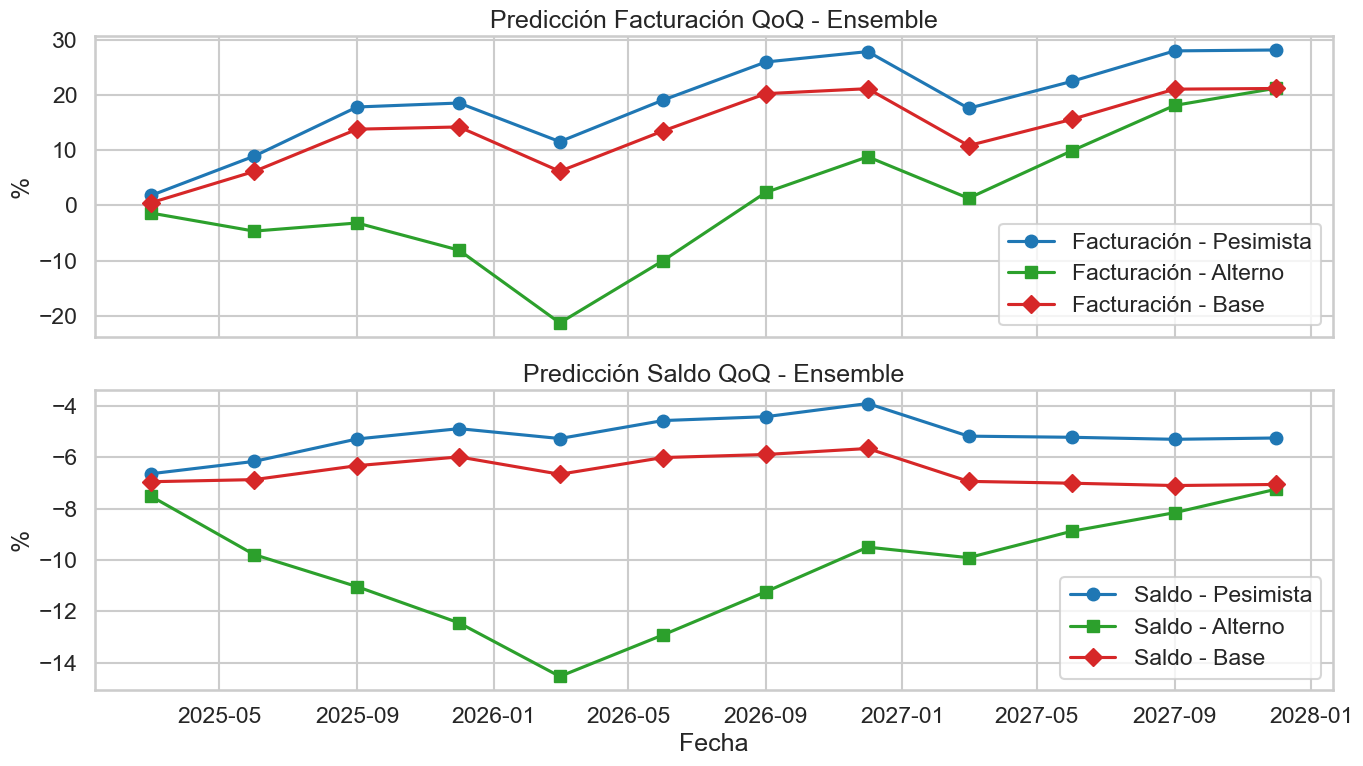

In [24]:
# Configuración de estilo
sns.set(style="whitegrid", context="talk")

# Crear figura con dos subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Colores y marcadores por escenario
escenarios_colores = {
    "Pesimista": ("tab:blue", "o"),
    "Alterno": ("tab:green", "s"),
    "Base": ("tab:red", "D"),
}

# ===============================
# Facturación - Ensemble
# ===============================
for esc, (color, marker) in escenarios_colores.items():
    df_plot = df_pred_fact[df_pred_fact["Escenario"] == esc]
    axes[0].plot(
        df_plot["Fecha"],
        df_plot["facturacion_ensemble"]*100,
        label=f"Facturación - {esc}",
        marker=marker,
        color=color
    )

axes[0].set_title("Predicción Facturación QoQ - Ensemble")
axes[0].set_ylabel("%")
axes[0].legend()
axes[0].grid(True)

# ===============================
# Saldo - Ensemble
# ===============================
for esc, (color, marker) in escenarios_colores.items():
    df_plot = df_pred_saldo[df_pred_saldo["Escenario"] == esc]
    axes[1].plot(
        df_plot["Fecha"],
        df_plot["saldo_ensemble"]*100,
        label=f"Saldo - {esc}",
        marker=marker,
        color=color
    )

axes[1].set_title("Predicción Saldo QoQ - Ensemble")
axes[1].set_ylabel("%")
axes[1].legend()
axes[1].grid(True)

# ===============================
# Ajustes finales
# ===============================
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()


### Conclusiones finales de los escenarios (Modelo Ensemble)

El análisis detallado de los escenarios se realiza a partir del **modelo Ensemble**, seleccionado por presentar el **menor error MAPE** durante el entrenamiento y validación cruzada. Las principales conclusiones son:

#### Facturación
- Los tres escenarios muestran **tendencias crecientes** durante el horizonte 2025–2027.
- **Pesimista:** Crecimiento continuo, alcanzando valores cercanos al 28 % en 2027, con picos en 2026 (≈26 %).
- **Alterno:** Presenta una **contracción fuerte en 2026** (caída de -21 %), seguida de una recuperación hasta 21 % al cierre de 2027.
- **Base:** Evolución intermedia, con un crecimiento estable y sostenido, llegando a 21 % en 2027.

#### Saldo
- A diferencia de la facturación, los escenarios de saldo mantienen valores **negativos durante todo el periodo**.
- **Pesimista:** Caídas moderadas entre -6 % y -5 %, con ligera mejora en 2026, pero sin alcanzar valores positivos.
- **Alterno:** La mayor contracción, hasta -14.5 % en marzo de 2026, con recuperación posterior, cerrando 2027 en -7 %.
- **Base:** Evolución similar al pesimista, con caídas suaves pero persistentes (entre -7 % y -5.6 %), cerrando 2027 en -7 %.

#### Interpretación general
- **Comportamiento divergente:** La **Facturación crece en todos los escenarios**, mientras que el **Saldo permanece en terreno negativo**.
- **Alta incertidumbre:** Los escenarios evidencian vulnerabilidad en la evolución del saldo y la dependencia de la facturación frente a las condiciones macroeconómicas (especialmente en 2026).
- Es fundamental incorporar más información y variables exógenas en futuras iteraciones para reducir la incertidumbre y mejorar la capacidad predictiva.